## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp033'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

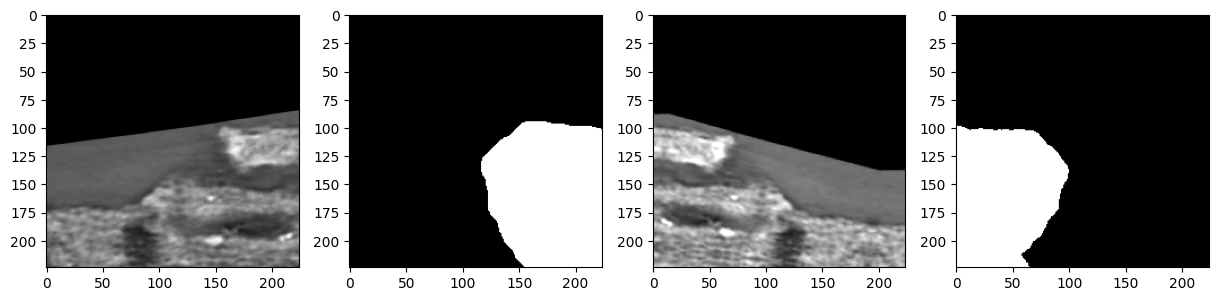

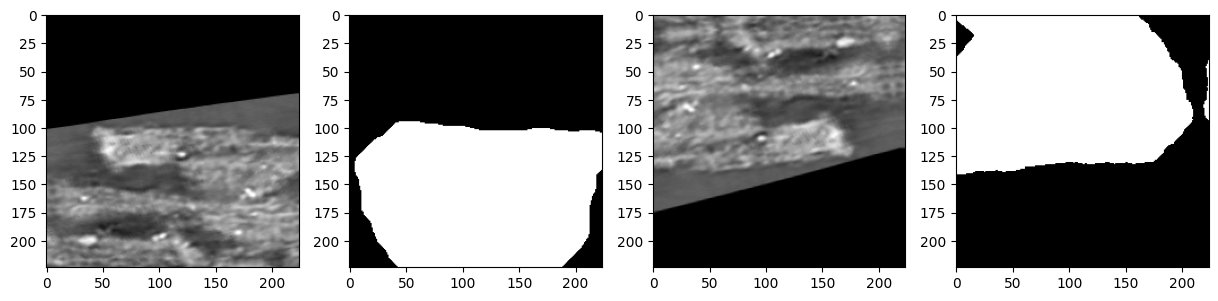

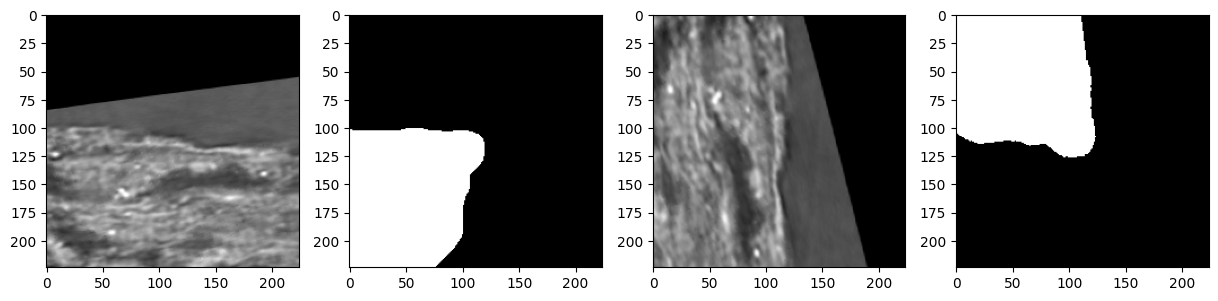

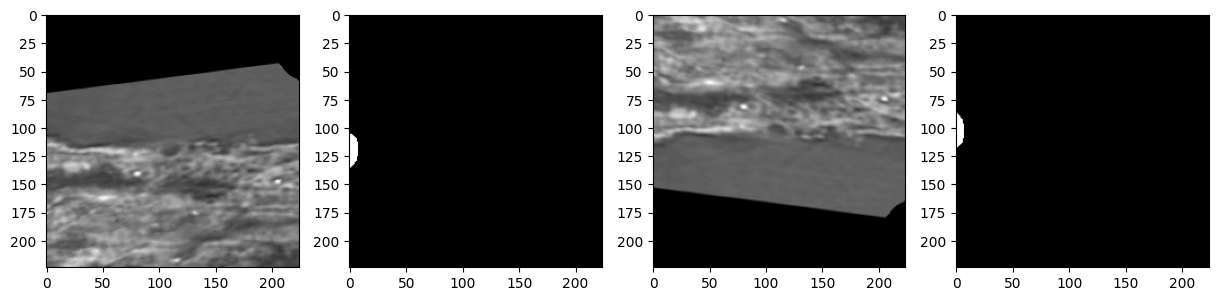

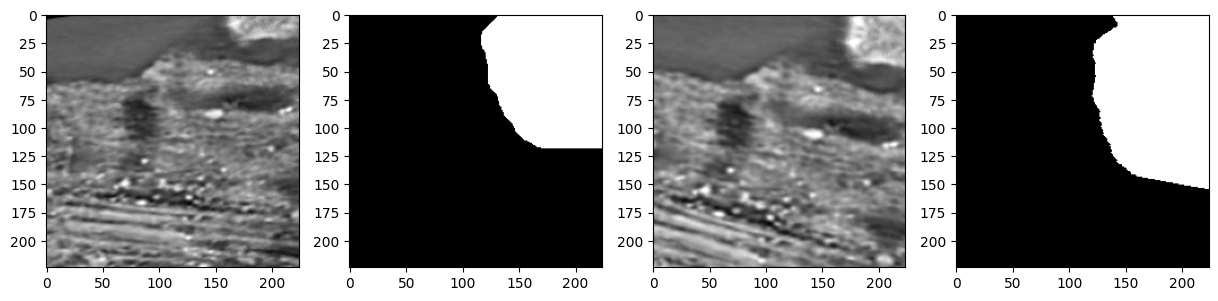

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53870

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14208309027826907
th: 0.15, fbeta: 0.14204113707771024
th: 0.2, fbeta: 0.14185922768729
th: 0.25, fbeta: 0.141525331058436
th: 0.3, fbeta: 0.19101777014706742
th: 0.35, fbeta: 0.2098341372164198
th: 0.4, fbeta: 0.22211813711909079
th: 0.45, fbeta: 0.23126042355924223


best_th: 0.45, fbeta: 0.23126042355924223
Epoch 1 - avg_train_loss: 0.6779  avg_val_loss: 0.5165  time: 114s
Epoch 1 - avgScore: 0.2313
Epoch 1 - Save Best Score: 0.2313 Model
Epoch 1 - Save Best Loss: 0.5165 Model


th: 0.5, fbeta: 0.23010604154227035


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420915803882949
th: 0.15, fbeta: 0.14209105156663493
th: 0.2, fbeta: 0.1458691381320491
th: 0.25, fbeta: 0.20613091892406837
th: 0.3, fbeta: 0.2462020014096321
th: 0.35, fbeta: 0.2801477075086236
th: 0.4, fbeta: 0.28019797512296246
th: 0.45, fbeta: 0.23253988271449855


best_th: 0.4, fbeta: 0.28019797512296246
Epoch 2 - avg_train_loss: 0.4630  avg_val_loss: 0.4138  time: 118s
Epoch 2 - avgScore: 0.2802
Epoch 2 - Save Best Score: 0.2802 Model
Epoch 2 - Save Best Loss: 0.4138 Model


th: 0.5, fbeta: 0.17692236715660545


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.31054911445268435
th: 0.15, fbeta: 0.3528082191671917
th: 0.2, fbeta: 0.32888988446556217
th: 0.25, fbeta: 0.2671913613569279
th: 0.3, fbeta: 0.21589063185507856
th: 0.35, fbeta: 0.16823195294472082
th: 0.4, fbeta: 0.12487946766142836
th: 0.45, fbeta: 0.08593773446355286


best_th: 0.15, fbeta: 0.3528082191671917
Epoch 3 - avg_train_loss: 0.2888  avg_val_loss: 0.3312  time: 118s
Epoch 3 - avgScore: 0.3528
Epoch 3 - Save Best Score: 0.3528 Model
Epoch 3 - Save Best Loss: 0.3312 Model


th: 0.5, fbeta: 0.05461855794005095


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35263836769259455
th: 0.15, fbeta: 0.30323646316063707
th: 0.2, fbeta: 0.23007950576323
th: 0.25, fbeta: 0.16759325425186117
th: 0.3, fbeta: 0.12041606206118151
th: 0.35, fbeta: 0.0872155622587828
th: 0.4, fbeta: 0.06562958369481604
th: 0.45, fbeta: 0.04913099534695127


best_th: 0.1, fbeta: 0.35263836769259455
Epoch 4 - avg_train_loss: 0.2178  avg_val_loss: 0.3730  time: 118s
Epoch 4 - avgScore: 0.3526


th: 0.5, fbeta: 0.0362330555971193


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3619826809741201
th: 0.15, fbeta: 0.39337481956562953
th: 0.2, fbeta: 0.39560851673713054
th: 0.25, fbeta: 0.371165545553653
th: 0.3, fbeta: 0.32517575898397744
th: 0.35, fbeta: 0.26969136209559896
th: 0.4, fbeta: 0.21665110951720817
th: 0.45, fbeta: 0.17106286374211588


best_th: 0.2, fbeta: 0.39560851673713054
Epoch 5 - avg_train_loss: 0.1956  avg_val_loss: 0.3436  time: 117s
Epoch 5 - avgScore: 0.3956
Epoch 5 - Save Best Score: 0.3956 Model
Epoch 5 - Save Best Loss: 0.3436 Model


th: 0.5, fbeta: 0.13104647832827968


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30482752405448077
th: 0.15, fbeta: 0.22119229623639158
th: 0.2, fbeta: 0.15246476622425642
th: 0.25, fbeta: 0.09739333050514014
th: 0.3, fbeta: 0.06257145194616162
th: 0.35, fbeta: 0.04025432286704015
th: 0.4, fbeta: 0.027155037368057012
th: 0.45, fbeta: 0.01636639695685238


best_th: 0.1, fbeta: 0.30482752405448077
Epoch 6 - avg_train_loss: 0.1787  avg_val_loss: 0.4691  time: 119s
Epoch 6 - avgScore: 0.3048


th: 0.5, fbeta: 0.009858704333454371


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4183274778843447
th: 0.15, fbeta: 0.4052944036832794
th: 0.2, fbeta: 0.3880234619848242
th: 0.25, fbeta: 0.3650036514302958
th: 0.3, fbeta: 0.33701949897115724
th: 0.35, fbeta: 0.3073316401219261
th: 0.4, fbeta: 0.2769180419423273
th: 0.45, fbeta: 0.24264537395099744


best_th: 0.1, fbeta: 0.4183274778843447
Epoch 7 - avg_train_loss: 0.1672  avg_val_loss: 0.4329  time: 118s
Epoch 7 - avgScore: 0.4183
Epoch 7 - Save Best Score: 0.4183 Model
Epoch 7 - Save Best Loss: 0.4329 Model


th: 0.5, fbeta: 0.21042110391174446


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3933424114018997
th: 0.15, fbeta: 0.37948123114921223
th: 0.2, fbeta: 0.35737143177473524
th: 0.25, fbeta: 0.32530089784034777
th: 0.3, fbeta: 0.2890326584094649
th: 0.35, fbeta: 0.2517349435942629
th: 0.4, fbeta: 0.21637541391455223
th: 0.45, fbeta: 0.18263340344444579


best_th: 0.1, fbeta: 0.3933424114018997
Epoch 8 - avg_train_loss: 0.1573  avg_val_loss: 0.4401  time: 120s
Epoch 8 - avgScore: 0.3933


th: 0.5, fbeta: 0.15201825982865966


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41911186040308057
th: 0.15, fbeta: 0.4111496769274442
th: 0.2, fbeta: 0.39243290963308247
th: 0.25, fbeta: 0.3727584970571593
th: 0.3, fbeta: 0.34633582419489983
th: 0.35, fbeta: 0.3161265537737135
th: 0.4, fbeta: 0.2850793581388313
th: 0.45, fbeta: 0.2539797211155477


best_th: 0.1, fbeta: 0.41911186040308057
Epoch 9 - avg_train_loss: 0.1455  avg_val_loss: 0.4888  time: 118s
Epoch 9 - avgScore: 0.4191
Epoch 9 - Save Best Score: 0.4191 Model
Epoch 9 - Save Best Loss: 0.4888 Model


th: 0.5, fbeta: 0.22286724836940197


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41743282137604426
th: 0.15, fbeta: 0.412754663084941
th: 0.2, fbeta: 0.3951144613768199
th: 0.25, fbeta: 0.36809833597228836
th: 0.3, fbeta: 0.34094446148858637
th: 0.35, fbeta: 0.31029797284193755
th: 0.4, fbeta: 0.2763190207951048
th: 0.45, fbeta: 0.24290595435822776


best_th: 0.1, fbeta: 0.41743282137604426
Epoch 10 - avg_train_loss: 0.1342  avg_val_loss: 0.4608  time: 120s
Epoch 10 - avgScore: 0.4174


th: 0.5, fbeta: 0.21249963815241973


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2709176423178652
th: 0.15, fbeta: 0.22667193931010662
th: 0.2, fbeta: 0.19215927477606543
th: 0.25, fbeta: 0.16093781906708357
th: 0.3, fbeta: 0.13674449618739656
th: 0.35, fbeta: 0.11542588329421533
th: 0.4, fbeta: 0.09525851393325198
th: 0.45, fbeta: 0.07597339005631214


best_th: 0.1, fbeta: 0.2709176423178652
Epoch 11 - avg_train_loss: 0.1253  avg_val_loss: 0.6212  time: 118s
Epoch 11 - avgScore: 0.2709


th: 0.5, fbeta: 0.05892057655819613


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38987364720789625
th: 0.15, fbeta: 0.36757651896779525
th: 0.2, fbeta: 0.34709531351379985
th: 0.25, fbeta: 0.32348127824819806
th: 0.3, fbeta: 0.294665018589325
th: 0.35, fbeta: 0.26579886543501086
th: 0.4, fbeta: 0.23564958044026063
th: 0.45, fbeta: 0.20312761732203452


best_th: 0.1, fbeta: 0.38987364720789625
Epoch 12 - avg_train_loss: 0.1189  avg_val_loss: 0.5453  time: 118s
Epoch 12 - avgScore: 0.3899


th: 0.5, fbeta: 0.17392760844315658


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.412042738122717
th: 0.15, fbeta: 0.4288853415101554
th: 0.2, fbeta: 0.4386661493247529
th: 0.25, fbeta: 0.44166024496455747
th: 0.3, fbeta: 0.4403214113567508
th: 0.35, fbeta: 0.43387878737097024
th: 0.4, fbeta: 0.4228169712242379
th: 0.45, fbeta: 0.4055632639835508


best_th: 0.25, fbeta: 0.44166024496455747
Epoch 13 - avg_train_loss: 0.1119  avg_val_loss: 0.4821  time: 118s
Epoch 13 - avgScore: 0.4417
Epoch 13 - Save Best Score: 0.4417 Model
Epoch 13 - Save Best Loss: 0.4821 Model


th: 0.5, fbeta: 0.3847892653612222


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40614213367225416
th: 0.15, fbeta: 0.38907367677238014
th: 0.2, fbeta: 0.36577124073938483
th: 0.25, fbeta: 0.3417091738042704
th: 0.3, fbeta: 0.3154396341201526
th: 0.35, fbeta: 0.28785411176022585
th: 0.4, fbeta: 0.2600914553064598
th: 0.45, fbeta: 0.23181790867478896


best_th: 0.1, fbeta: 0.40614213367225416
Epoch 14 - avg_train_loss: 0.1021  avg_val_loss: 0.5992  time: 120s
Epoch 14 - avgScore: 0.4061


th: 0.5, fbeta: 0.20137059059188822


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37678734533618935
th: 0.15, fbeta: 0.35187113444624596
th: 0.2, fbeta: 0.324548134414843
th: 0.25, fbeta: 0.29741936846331035
th: 0.3, fbeta: 0.2711552723783924
th: 0.35, fbeta: 0.24465555767320254
th: 0.4, fbeta: 0.21769030178618148
th: 0.45, fbeta: 0.18856976654924537


best_th: 0.1, fbeta: 0.37678734533618935
Epoch 15 - avg_train_loss: 0.0951  avg_val_loss: 0.6161  time: 118s
Epoch 15 - avgScore: 0.3768


th: 0.5, fbeta: 0.16135379084270782


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34077165492691475
th: 0.15, fbeta: 0.32473932127473437
th: 0.2, fbeta: 0.3050626754528795
th: 0.25, fbeta: 0.2811694661059928
th: 0.3, fbeta: 0.2596157292037664
th: 0.35, fbeta: 0.23636021365353108
th: 0.4, fbeta: 0.2131095259721348
th: 0.45, fbeta: 0.18759812682392374


best_th: 0.1, fbeta: 0.34077165492691475
Epoch 16 - avg_train_loss: 0.0920  avg_val_loss: 0.6812  time: 118s
Epoch 16 - avgScore: 0.3408


th: 0.5, fbeta: 0.1616631411859732


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3496159453396269
th: 0.15, fbeta: 0.336180997319452
th: 0.2, fbeta: 0.3203573578135343
th: 0.25, fbeta: 0.3002121006361885
th: 0.3, fbeta: 0.2784865415128243
th: 0.35, fbeta: 0.2562132648776392
th: 0.4, fbeta: 0.2322706063115867
th: 0.45, fbeta: 0.20574304978148178


best_th: 0.1, fbeta: 0.3496159453396269
Epoch 17 - avg_train_loss: 0.0875  avg_val_loss: 0.6704  time: 118s
Epoch 17 - avgScore: 0.3496


th: 0.5, fbeta: 0.17980557453259552


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4108368651049661
th: 0.15, fbeta: 0.4140259282524954
th: 0.2, fbeta: 0.41125215988733616
th: 0.25, fbeta: 0.40458898916343633
th: 0.3, fbeta: 0.3941751192072653
th: 0.35, fbeta: 0.3808443821821962
th: 0.4, fbeta: 0.3645261321481998
th: 0.45, fbeta: 0.3434010852555781


best_th: 0.15, fbeta: 0.4140259282524954
Epoch 18 - avg_train_loss: 0.0817  avg_val_loss: 0.6220  time: 118s
Epoch 18 - avgScore: 0.4140


th: 0.5, fbeta: 0.31992386390869604


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3713858140833331
th: 0.15, fbeta: 0.35463110166228995
th: 0.2, fbeta: 0.33206767938025294
th: 0.25, fbeta: 0.30829902186534
th: 0.3, fbeta: 0.28413399243038806
th: 0.35, fbeta: 0.2577850050506159
th: 0.4, fbeta: 0.23177696620149246
th: 0.45, fbeta: 0.2044076813720808


best_th: 0.1, fbeta: 0.3713858140833331
Epoch 19 - avg_train_loss: 0.0783  avg_val_loss: 0.6881  time: 119s
Epoch 19 - avgScore: 0.3714


th: 0.5, fbeta: 0.17598183092468764


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37967876297635633
th: 0.15, fbeta: 0.37449085614744365
th: 0.2, fbeta: 0.3651025023421708
th: 0.25, fbeta: 0.3523722269401452
th: 0.3, fbeta: 0.34048647668121557
th: 0.35, fbeta: 0.326522794966595
th: 0.4, fbeta: 0.30801506045109756
th: 0.45, fbeta: 0.28736223489645407


best_th: 0.1, fbeta: 0.37967876297635633
Epoch 20 - avg_train_loss: 0.0773  avg_val_loss: 0.7070  time: 119s
Epoch 20 - avgScore: 0.3797


th: 0.5, fbeta: 0.2641125073207604


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3983492422039546
th: 0.15, fbeta: 0.3980992073963125
th: 0.2, fbeta: 0.39438738965154974
th: 0.25, fbeta: 0.38792146294402596
th: 0.3, fbeta: 0.3793504212588693
th: 0.35, fbeta: 0.3676658834242714
th: 0.4, fbeta: 0.3523690524121682
th: 0.45, fbeta: 0.33336455042039304


best_th: 0.1, fbeta: 0.3983492422039546
Epoch 21 - avg_train_loss: 0.0710  avg_val_loss: 0.6782  time: 119s
Epoch 21 - avgScore: 0.3983


th: 0.5, fbeta: 0.3126734185251581


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36731199009113874
th: 0.15, fbeta: 0.3540937117616025
th: 0.2, fbeta: 0.3371038335926566
th: 0.25, fbeta: 0.31461363475806503
th: 0.3, fbeta: 0.29080551964457896
th: 0.35, fbeta: 0.2661325838905649
th: 0.4, fbeta: 0.23963534029521094
th: 0.45, fbeta: 0.21141209525775723


best_th: 0.1, fbeta: 0.36731199009113874
Epoch 22 - avg_train_loss: 0.0679  avg_val_loss: 0.7420  time: 119s
Epoch 22 - avgScore: 0.3673


th: 0.5, fbeta: 0.18299864432416368


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3370252766766817
th: 0.15, fbeta: 0.3085370932684082
th: 0.2, fbeta: 0.2787781684238541
th: 0.25, fbeta: 0.24990190181617558
th: 0.3, fbeta: 0.22229950534174223
th: 0.35, fbeta: 0.19967455568383927
th: 0.4, fbeta: 0.1781880991552243
th: 0.45, fbeta: 0.15566256869469952


best_th: 0.1, fbeta: 0.3370252766766817
Epoch 23 - avg_train_loss: 0.0665  avg_val_loss: 0.8220  time: 118s
Epoch 23 - avgScore: 0.3370


th: 0.5, fbeta: 0.12719808613223613


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40122084710133626
th: 0.15, fbeta: 0.3939039935383565
th: 0.2, fbeta: 0.38168194938147243
th: 0.25, fbeta: 0.3633136375061124
th: 0.3, fbeta: 0.3438154561191161
th: 0.35, fbeta: 0.3227650684019569
th: 0.4, fbeta: 0.2998557550056126
th: 0.45, fbeta: 0.2753001368867221


best_th: 0.1, fbeta: 0.40122084710133626
Epoch 24 - avg_train_loss: 0.0640  avg_val_loss: 0.7339  time: 119s
Epoch 24 - avgScore: 0.4012


th: 0.5, fbeta: 0.25036387968366586


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3658447207030253
th: 0.15, fbeta: 0.34977732955961627
th: 0.2, fbeta: 0.3305966052649669
th: 0.25, fbeta: 0.30575502488721984
th: 0.3, fbeta: 0.2820012804905195
th: 0.35, fbeta: 0.261251961489694
th: 0.4, fbeta: 0.2385539903968801
th: 0.45, fbeta: 0.2156114830776086


best_th: 0.1, fbeta: 0.3658447207030253
Epoch 25 - avg_train_loss: 0.0592  avg_val_loss: 0.8182  time: 119s
Epoch 25 - avgScore: 0.3658


th: 0.5, fbeta: 0.18994655426516902


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36154782991923673
th: 0.15, fbeta: 0.3471953203190668
th: 0.2, fbeta: 0.3265393804522794
th: 0.25, fbeta: 0.3020076788240817
th: 0.3, fbeta: 0.2788359458879441
th: 0.35, fbeta: 0.2554967309144907
th: 0.4, fbeta: 0.2311384514169162
th: 0.45, fbeta: 0.2045045131692366


best_th: 0.1, fbeta: 0.36154782991923673
Epoch 26 - avg_train_loss: 0.0581  avg_val_loss: 0.8262  time: 118s
Epoch 26 - avgScore: 0.3615


th: 0.5, fbeta: 0.1745089057929056


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3747464020274283
th: 0.15, fbeta: 0.36995647226292466
th: 0.2, fbeta: 0.3575376579608321
th: 0.25, fbeta: 0.34034830378655556
th: 0.3, fbeta: 0.32157100560352647
th: 0.35, fbeta: 0.3044700848637443
th: 0.4, fbeta: 0.28435501792182666
th: 0.45, fbeta: 0.26115738240858316


best_th: 0.1, fbeta: 0.3747464020274283
Epoch 27 - avg_train_loss: 0.0594  avg_val_loss: 0.7352  time: 119s
Epoch 27 - avgScore: 0.3747


th: 0.5, fbeta: 0.23283404496212295


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3657957973554553
th: 0.15, fbeta: 0.35109081317131835
th: 0.2, fbeta: 0.3333846255053097
th: 0.25, fbeta: 0.30921289121739337
th: 0.3, fbeta: 0.2862990358939075
th: 0.35, fbeta: 0.2650914416704326
th: 0.4, fbeta: 0.24228249083893066
th: 0.45, fbeta: 0.2169842202791383


best_th: 0.1, fbeta: 0.3657957973554553
Epoch 28 - avg_train_loss: 0.0559  avg_val_loss: 0.8074  time: 119s
Epoch 28 - avgScore: 0.3658


th: 0.5, fbeta: 0.1889010911309962


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37324502701885914
th: 0.15, fbeta: 0.3642255553783505
th: 0.2, fbeta: 0.34779920848000656
th: 0.25, fbeta: 0.326062913272297
th: 0.3, fbeta: 0.30540056251195374
th: 0.35, fbeta: 0.28371490862104404
th: 0.4, fbeta: 0.26026397147982655
th: 0.45, fbeta: 0.23339422680732919


best_th: 0.1, fbeta: 0.37324502701885914
Epoch 29 - avg_train_loss: 0.0535  avg_val_loss: 0.7860  time: 119s
Epoch 29 - avgScore: 0.3732


th: 0.5, fbeta: 0.20515987661156937


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3621020834500827
th: 0.15, fbeta: 0.34886700290508726
th: 0.2, fbeta: 0.3281276686516171
th: 0.25, fbeta: 0.3027763439113778
th: 0.3, fbeta: 0.2779613119811302
th: 0.35, fbeta: 0.25502723923061904
th: 0.4, fbeta: 0.22932504613079704
th: 0.45, fbeta: 0.2020587972284302


best_th: 0.1, fbeta: 0.3621020834500827
Epoch 30 - avg_train_loss: 0.0543  avg_val_loss: 0.8219  time: 118s
Epoch 30 - avgScore: 0.3621


th: 0.5, fbeta: 0.17529206057569122


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.412042738122717
th: 0.15, fbeta: 0.4288853415101554
th: 0.2, fbeta: 0.4386661493247529
th: 0.25, fbeta: 0.44166024496455747
th: 0.3, fbeta: 0.4403214113567508
th: 0.35, fbeta: 0.43387878737097024
th: 0.4, fbeta: 0.4228169712242379
th: 0.45, fbeta: 0.4055632639835508


best_th: 0.25, fbeta: 0.44166024496455747


th: 0.5, fbeta: 0.3847892653612222


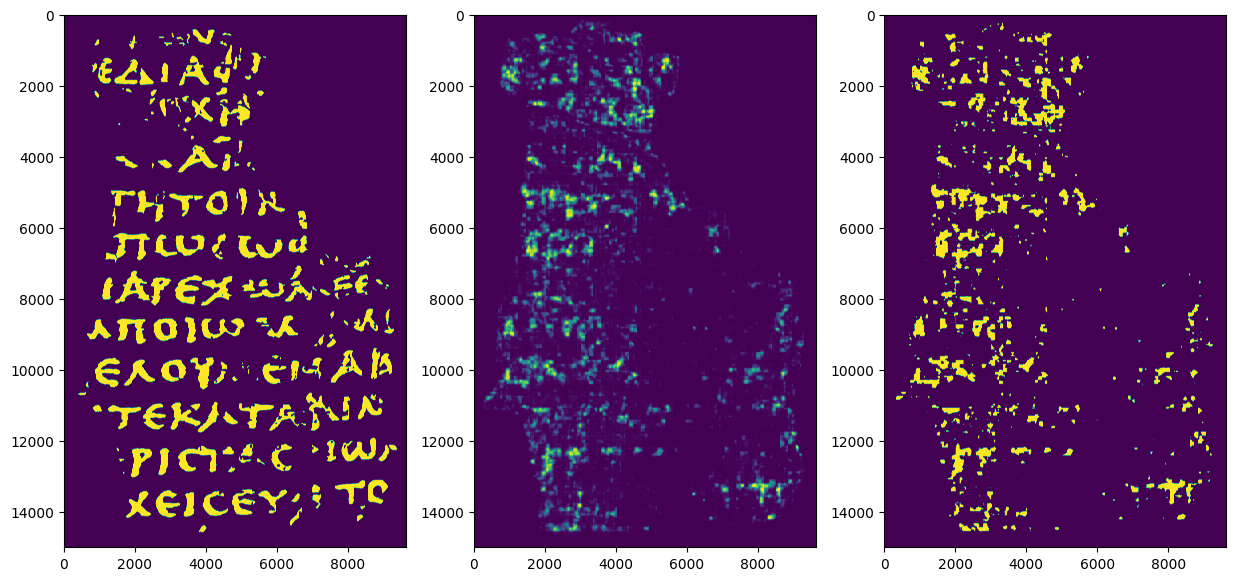

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.23507548e+08, 5.17763700e+06, 3.17639700e+06, 2.34506500e+06,
        1.75671200e+06, 1.44622400e+06, 1.13896600e+06, 9.14122000e+05,
        7.74568000e+05, 6.82866000e+05, 5.84010000e+05, 5.15507000e+05,
        4.81933000e+05, 4.33733000e+05, 3.86130000e+05, 3.42464000e+05,
        2.84907000e+05, 2.51837000e+05, 2.25556000e+05, 1.30874000e+05]),
 array([3.21581338e-05, 4.99090290e-02, 9.97858999e-02, 1.49662771e-01,
        1.99539642e-01, 2.49416513e-01, 2.99293383e-01, 3.49170254e-01,
        3.99047125e-01, 4.48923996e-01, 4.98800867e-01, 5.48677738e-01,
        5.98554609e-01, 6.48431480e-01, 6.98308351e-01, 7.48185221e-01,
        7.98062092e-01, 8.47938963e-01, 8.97815834e-01, 9.47692705e-01,
        9.97569576e-01]),
 <BarContainer object of 20 artists>)

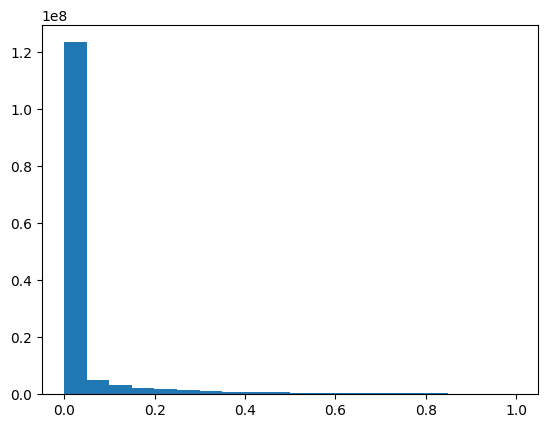

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000